In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063    0  4063    0     0  20624      0 --:--:-- --:--:-- --:--:-- 20624
100  517k  100  517k    0     0  1146k      0 --:--:-- --:--:-- --:--:-- 1146k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4039    0  4039    0     0  26127      0 --:--:-- --:--:-- --:--:-- 26227
100  392k  100  392k    0     0  1155k      0 --:--:-- --:--:-- --:--:-- 1155k


In [ ]:
!pip install TA-Lib yfinance pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.6/369.6 kB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (TA-Lib)


[*********************100%***********************]  1 of 1 completed


Market Data Overall Accuracy: 0.4814
Market Data Level-wise Accuracies: [0.4222222222222222, 0, 0.48573757131214346]
Market Data Level-wise Correct Predictions: [38, 0, 596]
Market Data Level-wise Incorrect Predictions: [52, 0, 631]


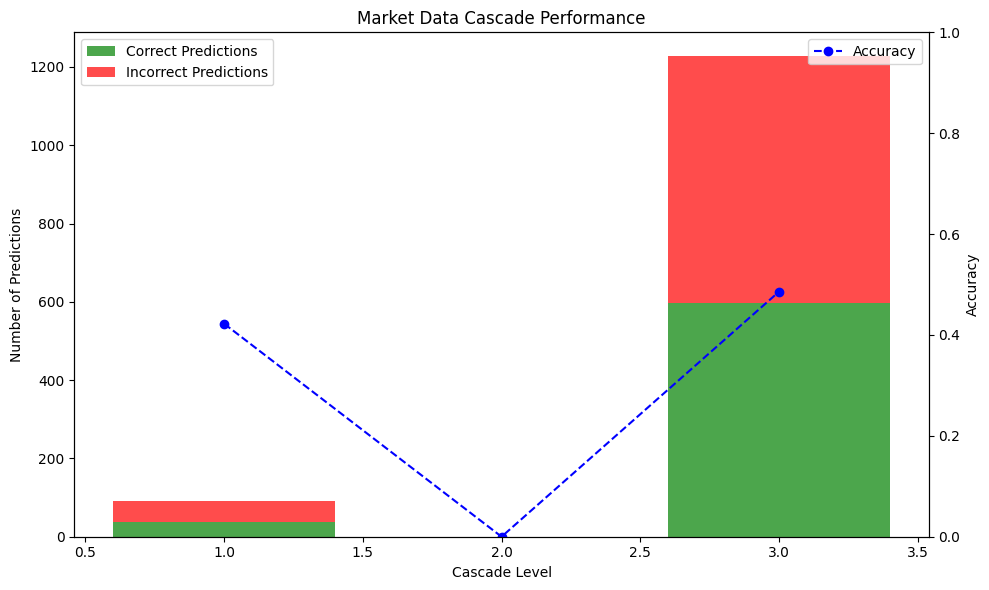

Synthetic Data Overall Accuracy: 1.0000
Synthetic Data Level-wise Accuracies: [1.0, 1.0, 1.0]
Synthetic Data Level-wise Correct Predictions: [704, 43, 8]
Synthetic Data Level-wise Incorrect Predictions: [0, 0, 0]


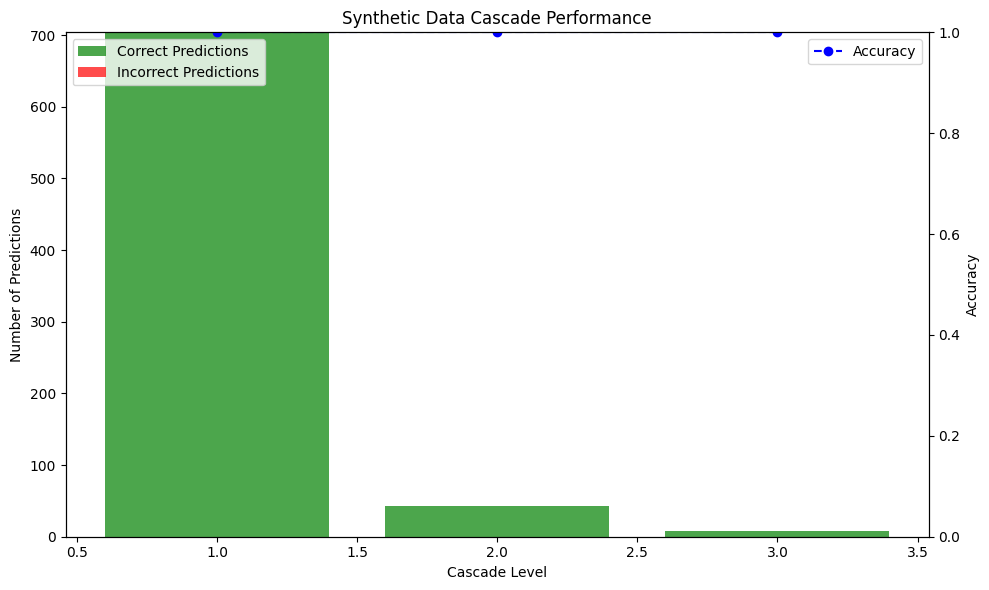

In [ ]:
# Install necessary libraries (uncomment if running in Colab)
# !pip install yfinance talib matplotlib scikit-learn

# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import talib as ta
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime, timedelta

# Function to fetch stock market data
def fetch_stock_data(ticker, start_date, end_date, interval='5m'):
    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
        if data.empty:
            print(f"No data found for {ticker} during the specified date range.")
            return pd.DataFrame()
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

# Add technical indicators
def add_technical_indicators(df):
    if 'Close' not in df.columns:
        raise ValueError("Error: 'Close' column not found in DataFrame!")
    close_prices = df['Close'].values.flatten()
    df['MA5'] = ta.SMA(close_prices, timeperiod=5)
    df['MA20'] = ta.SMA(close_prices, timeperiod=20)
    df['RSI'] = ta.RSI(close_prices, timeperiod=14)
    upper, middle, lower = ta.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_upper'] = upper
    df['BB_lower'] = lower
    macd, macdsignal, macdhist = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_signal'] = macdsignal
    return df.dropna()

# Generate targets
def generate_target(df, n_periods=10):
    df['Target'] = np.where(df['Close'].shift(-n_periods) > df['Close'], 1, 0)
    return df.dropna()

# Prepare data for training
def prepare_data(df):
    features = ['MA5', 'MA20', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal']
    X = df[features].values
    y = df['Target'].values
    return X, y

# Train cascade model
def train_cascade(X_train, y_train, num_models=3):
    models = []
    for i in range(num_models):
        model = MLPClassifier(hidden_layer_sizes=(10,), solver='adam', alpha=0.0001, max_iter=10000 )
        model.fit(X_train, y_train)
        models.append(model)
    return models

# Cascading prediction
def cascading_predict(models, X, y, max_impurity=0.05):
    unpruned = []
    level_accuracies = []
    correct_counts = []
    incorrect_counts = []

    for model in models:
        probs = model.predict_proba(X)
        correct_predictions = 0
        incorrect_predictions = 0
        total_predictions = 0
        next_X, next_y = [], []
        for idx, prob in enumerate(probs):
            gini = 1 - np.sum(prob ** 2)
            if gini <= max_impurity:
                if np.argmax(prob) == y[idx]:
                    correct_predictions += 1
                else:
                    incorrect_predictions += 1
                total_predictions += 1
                unpruned.append((prob, X[idx], y[idx]))
            else:
                next_X.append(X[idx])
                next_y.append(y[idx])
        level_accuracy = correct_predictions / total_predictions if total_predictions else 0
        level_accuracies.append(level_accuracy)
        correct_counts.append(correct_predictions)
        incorrect_counts.append(incorrect_predictions)
        X, y = np.array(next_X), np.array(next_y)

    return unpruned, level_accuracies, correct_counts, incorrect_counts

# Synthetic data generation
def generate_synthetic_data(size=1000):
    np.random.seed(42)
    X = np.random.rand(size, 7)
    y = (np.sum(X, axis=1) > 3.5).astype(int)
    return X, y

# Function to plot level-wise performance
def plot_level_performance(level_accuracies, correct_counts, incorrect_counts, title="Cascade Level Performance"):
    levels = range(1, len(level_accuracies) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for correct and incorrect counts
    ax1.bar(levels, correct_counts, label="Correct Predictions", color='green', alpha=0.7)
    ax1.bar(levels, incorrect_counts, label="Incorrect Predictions", color='red', alpha=0.7, bottom=correct_counts)
    ax1.set_ylabel("Number of Predictions")
    ax1.set_xlabel("Cascade Level")
    ax1.set_title(title)
    ax1.legend(loc="upper left")

    # Line graph for accuracy
    ax2 = ax1.twinx()
    ax2.plot(levels, level_accuracies, label="Accuracy", color='blue', marker='o', linestyle='--')
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim(0, 1)
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Main execution
ticker = "RELIANCE.NS"
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')

# Market data
stock_data = fetch_stock_data(ticker, start_date, end_date, interval='5m')
if not stock_data.empty:
    stock_data = add_technical_indicators(stock_data)
    stock_data = generate_target(stock_data)
    X_market, y_market = prepare_data(stock_data)
    market_models = train_cascade(X_market, y_market)
    unpruned_market, market_accuracies, market_correct, market_incorrect = cascading_predict(market_models, X_market, y_market)
    market_accuracy = accuracy_score([x[2] for x in unpruned_market], [np.argmax(x[0]) for x in unpruned_market])
    print(f"Market Data Overall Accuracy: {market_accuracy:.4f}")
    print("Market Data Level-wise Accuracies:", market_accuracies)
    print("Market Data Level-wise Correct Predictions:", market_correct)
    print("Market Data Level-wise Incorrect Predictions:", market_incorrect)
    plot_level_performance(market_accuracies, market_correct, market_incorrect, title="Market Data Cascade Performance")
else:
    print("Market data unavailable.")

# Synthetic data
X_synthetic, y_synthetic = generate_synthetic_data()
synthetic_models = train_cascade(X_synthetic, y_synthetic)
unpruned_synthetic, synthetic_accuracies, synthetic_correct, synthetic_incorrect = cascading_predict(synthetic_models, X_synthetic, y_synthetic)
synthetic_accuracy = accuracy_score([x[2] for x in unpruned_synthetic], [np.argmax(x[0]) for x in unpruned_synthetic])
print(f"Synthetic Data Overall Accuracy: {synthetic_accuracy:.4f}")
print("Synthetic Data Level-wise Accuracies:", synthetic_accuracies)
print("Synthetic Data Level-wise Correct Predictions:", synthetic_correct)
print("Synthetic Data Level-wise Incorrect Predictions:", synthetic_incorrect)
plot_level_performance(synthetic_accuracies, synthetic_correct, synthetic_incorrect, title="Synthetic Data Cascade Performance")
